In [226]:
# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import platform
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
get_ipython().run_line_magic("matplotlib", "inline")
path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Darwin":
    rc("font", family="Arial Unicode MS")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family=font_name)
else:
    print("Unknown system sorry.")
    
# 머신러닝
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from xgboost import XGBRegressor
from lightgbm import LGBMClassifier  
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 최적 군집 분석

In [61]:
big5_raw = pd.read_csv('./data/data-final.csv', delimiter='\t')
big5_raw.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,2016-03-03 02:01:20,1360.0,768.0,12.0,179.0,11,1,MY,3.1698,101.706
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,2016-03-03 02:01:56,1366.0,768.0,3.0,186.0,7,1,GB,54.9119,-1.3833
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,2016-03-03 02:02:02,1920.0,1200.0,186.0,219.0,7,1,GB,51.75,-1.25
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,...,2016-03-03 02:02:57,1366.0,768.0,8.0,315.0,17,2,KE,1.0,38.0


In [62]:
big5_raw.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015341 entries, 0 to 1015340
Data columns (total 110 columns):
 #    Column                 Dtype  
---   ------                 -----  
 0    EXT1                   float64
 1    EXT2                   float64
 2    EXT3                   float64
 3    EXT4                   float64
 4    EXT5                   float64
 5    EXT6                   float64
 6    EXT7                   float64
 7    EXT8                   float64
 8    EXT9                   float64
 9    EXT10                  float64
 10   EST1                   float64
 11   EST2                   float64
 12   EST3                   float64
 13   EST4                   float64
 14   EST5                   float64
 15   EST6                   float64
 16   EST7                   float64
 17   EST8                   float64
 18   EST9                   float64
 19   EST10                  float64
 20   AGR1                   float64
 21   AGR2                   float6

In [63]:
big5_raw = big5_raw[big5_raw['IPC'] == 1]
# 결측치 제거
big5_raw.dropna(inplace=True)

In [64]:
# 문항에 긍정으로 답하는게 부정적인 경우 거꾸로 뒤집어 줌
big5_raw['EXT2'] = 5 - big5_raw['EXT2'] 
big5_raw['EXT4'] = 5 - big5_raw['EXT4'] 
big5_raw['EXT6'] = 5 - big5_raw['EXT6'] 
big5_raw['EXT8'] = 5 - big5_raw['EXT8'] 
big5_raw['EXT10'] = 5 - big5_raw['EXT10']  
big5_raw['EST4'] = 5 - big5_raw['EST4'] 
big5_raw['EST5'] = 5 - big5_raw['EST5']  
big5_raw['AGR1'] = 5 - big5_raw['AGR1'] 
big5_raw['AGR3'] = 5 - big5_raw['AGR3'] 
big5_raw['AGR5'] = 5 - big5_raw['AGR5'] 
big5_raw['AGR7'] = 5 - big5_raw['AGR7']  
big5_raw['CSN2'] = 5 - big5_raw['CSN2'] 
big5_raw['CSN4'] = 5 - big5_raw['CSN4'] 
big5_raw['CSN6'] = 5 - big5_raw['CSN6'] 
big5_raw['CSN8'] = 5 - big5_raw['CSN8']  
big5_raw['OPN2'] = 5 - big5_raw['OPN2'] 
big5_raw['OPN4'] = 5 - big5_raw['OPN4'] 
big5_raw['OPN6'] = 5 - big5_raw['OPN6']

In [65]:
# 필요없는 칼럼 제거
big5_raw.drop(['dateload', 'screenw', 'screenh', 'introelapse', 'testelapse', 'endelapse', 'IPC', 'lat_appx_lots_of_err','long_appx_lots_of_err'], axis=1, inplace=True)

In [66]:
# 일단 나라별로 문항 답변 데이터 집계

def ag(x):
    lis = list(x.columns)
    lis.remove('Count')
    lis.remove('country')
    dic = dict()
    for i in lis:
        dic[i] = 'mean'
    dic['Count'] = 'sum'
    return dic
    
big5_raw['Count'] = 1
big5_country = big5_raw.groupby(['country']).agg(ag(big5_raw))
big5_country.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,Count
country,,,,,,,,,,,,,,,,,,,,,
AD,2.666667,2.066667,2.866667,1.733333,3.400000,2.266667,3.066667,1.800000,2.866667,1.466667,...,7022.000000,4467.866667,7435.266667,4351.466667,4839.200000,5020.800000,3930.733333,5394.400000,3681.866667,15
AE,2.722010,2.103349,3.241627,1.860287,3.260766,2.384689,2.778469,1.763158,3.163158,1.497608,...,8848.950239,7826.140670,10244.434450,4158.619139,10281.193301,7831.704785,5712.321053,6030.011005,15184.092344,2090
AF,2.978261,2.152174,3.282609,1.739130,3.630435,2.456522,3.043478,1.630435,3.195652,1.608696,...,13827.652174,5621.347826,11671.521739,3797.130435,3786.739130,5406.304348,3295.282609,6474.021739,3929.608696,46
AG,2.318182,2.000000,3.045455,1.590909,3.590909,2.636364,2.272727,1.409091,2.227273,1.363636,...,7889.863636,4340.090909,5219.909091,3357.227273,3385.500000,4432.227273,14682.727273,4271.909091,3565.363636,22
AI,2.500000,2.000000,3.750000,1.500000,3.250000,2.500000,3.000000,1.000000,2.250000,1.000000,...,3339.500000,1883.250000,3780.750000,2875.000000,3700.750000,3813.250000,4399.750000,3697.750000,1842.500000,4


In [78]:
big5_country = big5_country.iloc[:,:50]

In [79]:
scaler = StandardScaler()
big5_country_scaled = pd.DataFrame(scaler.fit_transform(big5_country), columns=big5_country.columns)
big5_country_scaled.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,0.373712,-0.028064,-0.758217,-0.044919,0.533867,-0.510401,1.045447,0.419577,-0.202862,0.160805,...,-0.209012,-0.607197,-0.452418,-0.078521,-0.056157,0.345779,-0.980833,-0.123091,0.517455,0.138360
1,0.493422,0.060291,0.184768,0.255045,0.200540,-0.229826,0.391425,0.335444,0.419401,0.239640,...,-0.455060,-0.527615,-0.029355,-0.571331,-0.114545,-0.090445,-0.203462,-0.536888,-0.408021,-0.181966
2,1.047708,0.177891,0.287833,-0.031222,1.085528,-0.059058,0.992824,0.032355,0.487598,0.522682,...,-0.564499,-1.370310,-0.085318,-1.341587,-0.639784,-1.384480,-0.354229,-0.569111,-0.284650,-0.147011
3,-0.380081,-0.188640,-0.308585,-0.381437,0.990904,0.368480,-0.756280,-0.473109,-1.544794,-0.101708,...,0.358235,-0.247979,0.762905,1.001869,-0.278032,1.026883,-0.575528,0.204241,0.775474,0.257697
4,0.013202,-0.188640,1.463271,-0.596235,0.174767,0.044303,0.894157,-1.407316,-1.497095,-1.028222,...,1.727453,0.127948,0.602994,0.581717,-0.208696,1.756638,-0.928991,2.288667,0.872232,1.451066


In [69]:
#!pip install yellowbrick

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Owner\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Owner\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


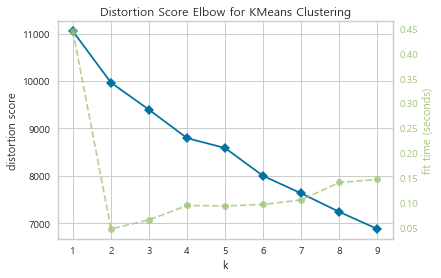

In [87]:
# elbow 점수

km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,10))
visualizer.fit(big5_country_scaled)
visualizer.show();

In [72]:
# 실루엣 점수
result = []

for i in range(2,8):
    km =  KMeans(n_clusters=i, max_iter=50, init='k-means++').fit(big5_country_scaled)
    result.append(silhouette_score(big5_country_scaled, km.labels_))

In [73]:
for i, item in enumerate(result):
    print(f'Cluster: {i+2}, Silhouette Score: {item}')

Cluster: 2, Silhouette Score: 0.3267889043022207
Cluster: 3, Silhouette Score: 0.22962311852651818
Cluster: 4, Silhouette Score: 0.14437204422022196
Cluster: 5, Silhouette Score: 0.11044869487617295
Cluster: 6, Silhouette Score: 0.16209256570656466
Cluster: 7, Silhouette Score: 0.0979416891896271


- Best Cluster number
    - elbow: 5
    - silhouette: 4

- 두가지 모델 각각 비교

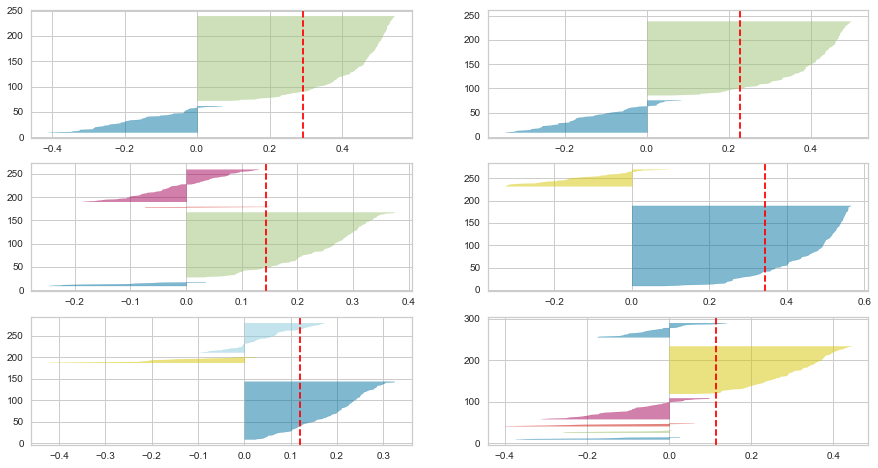

In [13]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(big5_country_scaled) 

- 실루엣 분석을 통해선 효과적으로 클러스터링이 된것 같지 않다.
- elbow를 통해 4일때 실제 데이터가 어떤지 다시 한번 보자

# 군집 4개로 분류

In [88]:
choose_cluster = KMeans(n_clusters=4, max_iter=100, init='k-means++', random_state=13)
choose_cluster.fit(big5_country_scaled)

KMeans(max_iter=100, n_clusters=4, random_state=13)

In [89]:
pca_df = big5_country_scaled.copy()
pca_df['Cluster_Id'] = choose_cluster.labels_
pca_df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,Cluster_Id
0,0.373712,-0.028064,-0.758217,-0.044919,0.533867,-0.510401,1.045447,0.419577,-0.202862,0.160805,...,-0.607197,-0.452418,-0.078521,-0.056157,0.345779,-0.980833,-0.123091,0.517455,0.138360,1
1,0.493422,0.060291,0.184768,0.255045,0.200540,-0.229826,0.391425,0.335444,0.419401,0.239640,...,-0.527615,-0.029355,-0.571331,-0.114545,-0.090445,-0.203462,-0.536888,-0.408021,-0.181966,2
2,1.047708,0.177891,0.287833,-0.031222,1.085528,-0.059058,0.992824,0.032355,0.487598,0.522682,...,-1.370310,-0.085318,-1.341587,-0.639784,-1.384480,-0.354229,-0.569111,-0.284650,-0.147011,1
3,-0.380081,-0.188640,-0.308585,-0.381437,0.990904,0.368480,-0.756280,-0.473109,-1.544794,-0.101708,...,-0.247979,0.762905,1.001869,-0.278032,1.026883,-0.575528,0.204241,0.775474,0.257697,1
4,0.013202,-0.188640,1.463271,-0.596235,0.174767,0.044303,0.894157,-1.407316,-1.497095,-1.028222,...,0.127948,0.602994,0.581717,-0.208696,1.756638,-0.928991,2.288667,0.872232,1.451066,1


In [90]:
# Summing up the different questions groups
col_list = list(pca_df)
ext = col_list[0:10]
est = col_list[10:20]
agr = col_list[20:30]
csn = col_list[30:40]
opn = col_list[40:50]

data_sums = pd.DataFrame()
data_sums['extroversion'] = pca_df[ext].sum(axis=1)/10
data_sums['neurotic'] = pca_df[est].sum(axis=1)/10
data_sums['agreeable'] = pca_df[agr].sum(axis=1)/10
data_sums['conscientious'] = pca_df[csn].sum(axis=1)/10
data_sums['open'] = pca_df[opn].sum(axis=1)/10
data_sums['clusters'] = choose_cluster.labels_
data_sums.groupby('clusters').mean()

,extroversion,neurotic,agreeable,conscientious,open
clusters,,,,,
0,-0.169963,-0.162326,1.016006,-1.333521,0.955095
1,0.017072,-0.191871,0.307591,0.377756,0.068414
2,-0.117028,0.180728,-0.297114,-0.195752,-0.124674
3,1.751691,-0.974699,0.915113,1.224469,0.333747


In [91]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(pca_df)

pca_result = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
pca_result['Clusters'] = choose_cluster.labels_
pca_result.head()

,PCA1,PCA2,Clusters
0,1.225633,0.167172,1
1,0.006580,0.062220,2
2,0.140315,-1.997547,1
3,-0.210739,-1.156328,1
4,4.029355,1.568324,1


C:\Users\Owner\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Owner\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


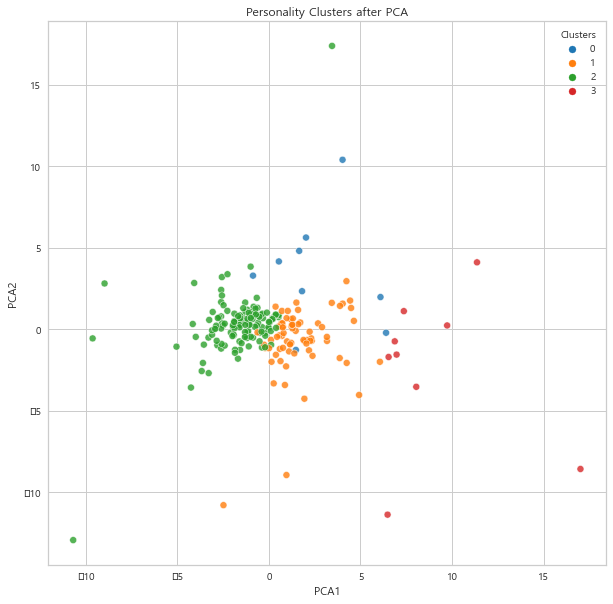

In [94]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=pca_result, x='PCA1', y='PCA2', hue='Clusters', palette='tab10', alpha=0.8)
plt.title('Personality Clusters after PCA')
plt.show();

 - raw_data에 대해서 다시

In [95]:
big5_raw.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,country,Count
0,4.0,4.0,5.0,3.0,5.0,4.0,5.0,3.0,4.0,4.0,...,2959.0,3411.0,2170.0,4920.0,4436.0,3116.0,2992.0,4354.0,GB,1
1,3.0,0.0,3.0,1.0,3.0,2.0,2.0,0.0,1.0,0.0,...,1684.0,3026.0,4742.0,3336.0,2718.0,3374.0,3096.0,3019.0,MY,1
2,2.0,2.0,4.0,1.0,3.0,3.0,1.0,2.0,2.0,0.0,...,1644.0,1683.0,2229.0,8114.0,2043.0,6295.0,1585.0,2529.0,GB,1
3,2.0,3.0,2.0,2.0,4.0,3.0,2.0,1.0,1.0,1.0,...,1977.0,3728.0,4128.0,3776.0,2984.0,4192.0,3480.0,3257.0,GB,1
5,3.0,2.0,4.0,3.0,4.0,3.0,2.0,2.0,3.0,1.0,...,3656.0,4352.0,2681.0,3272.0,2640.0,1568.0,1640.0,3192.0,SE,1


In [96]:
raw_question_info = big5_raw.iloc[:,:50]
raw_question_info.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,4.0,4.0,5.0,3.0,5.0,4.0,5.0,3.0,4.0,4.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,3.0,4.0,5.0
1,3.0,0.0,3.0,1.0,3.0,2.0,2.0,0.0,1.0,0.0,...,1.0,3.0,4.0,3.0,3.0,4.0,4.0,2.0,5.0,3.0
2,2.0,2.0,4.0,1.0,3.0,3.0,1.0,2.0,2.0,0.0,...,5.0,4.0,2.0,4.0,4.0,3.0,5.0,3.0,4.0,4.0
3,2.0,3.0,2.0,2.0,4.0,3.0,2.0,1.0,1.0,1.0,...,4.0,3.0,5.0,3.0,3.0,4.0,4.0,4.0,3.0,3.0
5,3.0,2.0,4.0,3.0,4.0,3.0,2.0,2.0,3.0,1.0,...,5.0,4.0,5.0,4.0,3.0,4.0,5.0,4.0,5.0,2.0


In [97]:
raw_cluster = KMeans(n_clusters= 4, init='k-means++', max_iter=200, random_state=13)
raw_cluster.fit(raw_question_info)

KMeans(max_iter=200, n_clusters=4, random_state=13)

In [98]:
raw_question_info['Clusters'] = raw_cluster.labels_

In [99]:
# Summing up the different questions groups
col_list = list(raw_question_info)
ext = col_list[0:10]
est = col_list[10:20]
agr = col_list[20:30]
csn = col_list[30:40]
opn = col_list[40:50]

data_sums = pd.DataFrame()
data_sums['extroversion'] = raw_question_info[ext].sum(axis=1)/10
data_sums['neurotic'] = raw_question_info[est].sum(axis=1)/10
data_sums['agreeable'] = raw_question_info[agr].sum(axis=1)/10
data_sums['conscientious'] = raw_question_info[csn].sum(axis=1)/10
data_sums['open'] = raw_question_info[opn].sum(axis=1)/10
data_sums['clusters'] = raw_cluster.labels_
data_sums.groupby('clusters').mean()

,extroversion,neurotic,agreeable,conscientious,open
clusters,,,,,
0,3.082132,2.436565,3.805456,3.463432,3.753473
1,1.883258,2.532803,2.710570,2.958885,3.479828
2,3.122014,3.244447,3.529126,2.530405,3.748952
3,1.609911,3.439065,3.258881,2.763894,3.472814


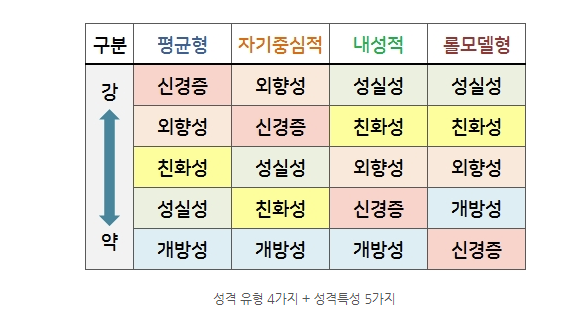

In [24]:
from IPython.display import Image
Image(filename='image.png')

- 외향성:extroversion, 친화성:agreeableness, 성실성: conscientiousness, 개방성: openness, 신경성: neurotic 에 따라서 매칭시켜 보기

In [101]:
personality_result = data_sums.groupby('clusters').mean()
personality_result

,extroversion,neurotic,agreeable,conscientious,open
clusters,,,,,
0,3.082132,2.436565,3.805456,3.463432,3.753473
1,1.883258,2.532803,2.710570,2.958885,3.479828
2,3.122014,3.244447,3.529126,2.530405,3.748952
3,1.609911,3.439065,3.258881,2.763894,3.472814


In [102]:
# 평균형
personality_result.sort_values(by=["neurotic", "extroversion", "agreeable", "conscientious","open"], ascending=False)

,extroversion,neurotic,agreeable,conscientious,open
clusters,,,,,
3,1.609911,3.439065,3.258881,2.763894,3.472814
2,3.122014,3.244447,3.529126,2.530405,3.748952
1,1.883258,2.532803,2.710570,2.958885,3.479828
0,3.082132,2.436565,3.805456,3.463432,3.753473


In [103]:
# 자기중심적
personality_result.sort_values(by=["extroversion", "neurotic", "conscientious", "agreeable", "open"], ascending=False)

,extroversion,neurotic,agreeable,conscientious,open
clusters,,,,,
2,3.122014,3.244447,3.529126,2.530405,3.748952
0,3.082132,2.436565,3.805456,3.463432,3.753473
1,1.883258,2.532803,2.710570,2.958885,3.479828
3,1.609911,3.439065,3.258881,2.763894,3.472814


In [104]:
# 내성적
personality_result.sort_values(by=["conscientious", "agreeable", "extroversion", "neurotic", "open"], ascending=False)

,extroversion,neurotic,agreeable,conscientious,open
clusters,,,,,
0,3.082132,2.436565,3.805456,3.463432,3.753473
1,1.883258,2.532803,2.710570,2.958885,3.479828
3,1.609911,3.439065,3.258881,2.763894,3.472814
2,3.122014,3.244447,3.529126,2.530405,3.748952


- 평균형: cluster1
- 자기중심형: cluster0
- 내성적: cluster3
- 롤모델형: cluster2

In [105]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(raw_question_info)

df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca['Clusters'] = raw_cluster.labels_
df_pca.head()

,PCA1,PCA2,Clusters
0,-5.686289,-1.860261,0
1,-0.196044,3.035888,1
2,-1.001568,2.018697,1
3,0.815287,0.258068,1
4,-3.231531,2.289002,0


C:\Users\Owner\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Owner\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


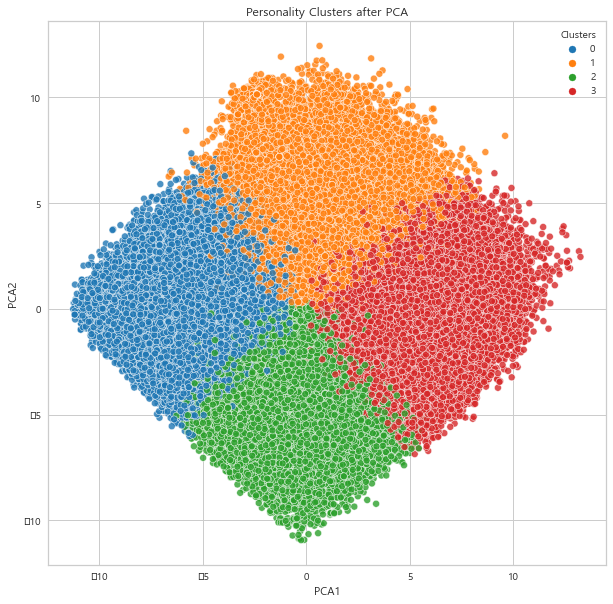

In [106]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Clusters', palette='tab10', alpha=0.8)
plt.title('Personality Clusters after PCA');

# 군집 중심값의 거리에 따라서 영화 데이터에 라벨링

In [107]:
raw_cluster.cluster_centers_.shape

(4, 50)

In [108]:
# 각 클러스터별 센터
tmp = pd.DataFrame(raw_cluster.cluster_centers_, columns=raw_question_info.columns.to_list()[:-1])
tmp

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,3.169329,2.785331,4.122466,2.481095,4.053749,3.174278,3.542772,1.913512,3.432858,2.153588,...,3.876668,3.196142,4.047189,3.166206,4.083773,3.298586,4.287700,3.195155,4.181787,4.201897
1,1.999396,1.493654,2.721218,1.363347,2.487476,2.119172,1.951178,1.237832,2.484659,0.983205,...,3.635202,3.055545,3.702434,2.991603,3.667603,2.975714,3.990506,3.155237,3.918285,3.709840
2,3.363809,3.025173,3.715800,2.452173,3.985208,3.164525,3.554314,2.228191,3.743170,1.976667,...,3.863052,2.986787,4.286438,3.113502,3.987126,3.275742,4.032676,3.477590,4.236151,4.229093
3,1.791873,1.390442,2.339518,0.954836,2.383307,1.895672,1.763903,0.887744,2.135658,0.547272,...,3.567277,2.689100,4.066647,2.910891,3.495994,2.961681,3.771603,3.170119,4.343956,3.747870


In [109]:
personality_result.reset_index(inplace=True)
personality_result

,clusters,extroversion,neurotic,agreeable,conscientious,open
0,0,3.082132,2.436565,3.805456,3.463432,3.753473
1,1,1.883258,2.532803,2.710570,2.958885,3.479828
2,2,3.122014,3.244447,3.529126,2.530405,3.748952
3,3,1.609911,3.439065,3.258881,2.763894,3.472814


In [110]:
personality_result['Personality_Type'] = ['자기중심형', '평균형', '롤모델형', '내성적형']
personality_result

,clusters,extroversion,neurotic,agreeable,conscientious,open,Personality_Type
0,0,3.082132,2.436565,3.805456,3.463432,3.753473,자기중심형
1,1,1.883258,2.532803,2.710570,2.958885,3.479828,평균형
2,2,3.122014,3.244447,3.529126,2.530405,3.748952,롤모델형
3,3,1.609911,3.439065,3.258881,2.763894,3.472814,내성적형


In [111]:
movie_user_info = pd.read_csv('../방아현/data/2018-personality-data.csv')
movie_user_info.columns = movie_user_info.columns.str.strip()
movie_user_big5 = movie_user_info[['userid', 'openness', 'agreeableness', 'emotional_stability',
		'conscientiousness', 'extraversion']]
movie_user_big5.head()

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5
1,77c7d756a093150d4377720abeaeef76,7.0,4.0,6.0,5.5,4.0
2,b7e8a92987a530cc368719a0e60e26a3,4.0,3.0,4.5,2.0,2.5
3,92561f21446e017dd6b68b94b23ad5b7,5.5,5.5,4.0,4.5,4.0
4,030001ac2145a938b07e686a35a2d638,5.5,5.5,3.5,4.5,2.5


In [112]:
user_ratings = pd.read_csv('../방아현/data/new_ratings.csv', index_col=0)
user_ratings.head()

C:\Users\Owner\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,userid,movie_id,rating,tstamp,expected_name
0,8e7cebf9a234c064b75016249f2ac65e,1,5.0,2001-09-10 17:19:56,Toy Story (1995)
1,8e7cebf9a234c064b75016249f2ac65e,2,4.0,2001-09-28 11:34:55,Jumanji (1995)
2,8e7cebf9a234c064b75016249f2ac65e,3,4.0,2001-09-28 11:42:50,Grumpier Old Men (1995)
3,8e7cebf9a234c064b75016249f2ac65e,5,5.0,2001-09-28 11:27:30,Father of the Bride Part II (1995)
4,8e7cebf9a234c064b75016249f2ac65e,6,4.0,2002-01-07 18:12:02,Heat (1995)


- 위 성격은 만점이 7점 따라서 만점이 5점이라 쳤을떄의 결과로 환산시킨다.

In [113]:
movie_user_big5['openness'] = (movie_user_big5['openness'] / 7) *5
movie_user_big5['agreeableness'] = (movie_user_big5['agreeableness'] / 7) *5
movie_user_big5['emotional_stability'] = (movie_user_big5['emotional_stability'] / 7) *5
movie_user_big5['conscientiousness'] = (movie_user_big5['conscientiousness'] / 7) *5
movie_user_big5['extraversion'] = (movie_user_big5['extraversion'] / 7) *5

movie_user_big5.head()

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_17168/3807962954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_user_big5['openness'] = (movie_user_big5['openness'] / 7) *5
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_17168/3807962954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_user_big5['agreeableness'] = (movie_user_big5['agreeableness'] / 7) *5
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_17168/3807962954.py:3: SettingWithCopyWarning: 
A value is try

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion
0,8e7cebf9a234c064b75016249f2ac65e,3.571429,1.428571,2.142857,1.785714,4.642857
1,77c7d756a093150d4377720abeaeef76,5.000000,2.857143,4.285714,3.928571,2.857143
2,b7e8a92987a530cc368719a0e60e26a3,2.857143,2.142857,3.214286,1.428571,1.785714
3,92561f21446e017dd6b68b94b23ad5b7,3.928571,3.928571,2.857143,3.214286,2.857143
4,030001ac2145a938b07e686a35a2d638,3.928571,3.928571,2.500000,3.214286,1.785714


In [114]:
personality_result.columns

Index(['clusters', 'extroversion', 'neurotic', 'agreeable', 'conscientious',
       'open', 'Personality_Type'],
      dtype='object')

In [115]:
user_cluster = []
user_type = []

for index, row in movie_user_big5.iterrows():
    distance = []
    # KNN
    for p_index, p_row in personality_result.iterrows():
        openness = (row['openness'] - p_row['open']) ** 2
        agreeableness = (row['agreeableness'] - p_row['agreeable']) ** 2
        emotional_stable = (row['emotional_stability'] - p_row['neurotic']) ** 2
        conscientious = (row['conscientiousness'] - p_row['conscientious']) ** 2
        extra = (row['extraversion'] - p_row['extroversion']) ** 2

        result = np.sqrt(openness + agreeableness + emotional_stable + conscientious + extra)
        distance.append((result, p_row['clusters'], p_row['Personality_Type']))
    
    # distance sort for finding minimum distance
    distance.sort(key=lambda x: x[0])
    user_cluster.append(distance[0][1])
    user_type.append(distance[0][2])


In [116]:
movie_user_big5['clusters'] = user_cluster
movie_user_big5['user_type'] = user_type

movie_user_big5.head()

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_17168/1284255478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_user_big5['clusters'] = user_cluster
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_17168/1284255478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_user_big5['user_type'] = user_type


,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion,clusters,user_type
0,8e7cebf9a234c064b75016249f2ac65e,3.571429,1.428571,2.142857,1.785714,4.642857,2,롤모델형
1,77c7d756a093150d4377720abeaeef76,5.000000,2.857143,4.285714,3.928571,2.857143,2,롤모델형
2,b7e8a92987a530cc368719a0e60e26a3,2.857143,2.142857,3.214286,1.428571,1.785714,3,내성적형
3,92561f21446e017dd6b68b94b23ad5b7,3.928571,3.928571,2.857143,3.214286,2.857143,0,자기중심형
4,030001ac2145a938b07e686a35a2d638,3.928571,3.928571,2.500000,3.214286,1.785714,1,평균형


- 최종 모델

In [123]:
# 분류 데이터 save
movie_user_big5.to_csv('./data/personality_result.csv')

In [122]:
movie_user_big5['user_type'].value_counts()

평균형      522
내성적형     486
롤모델형     462
자기중심형    364
Name: user_type, dtype: int64

# 분류 모델링

### 성격별 군집 데이터 EDA

In [143]:
df = movie_user_big5.drop(['userid', 'user_type'], axis=1)
df

,openness,agreeableness,emotional_stability,conscientiousness,extraversion,clusters
0,3.571429,1.428571,2.142857,1.785714,4.642857,2
1,5.000000,2.857143,4.285714,3.928571,2.857143,2
2,2.857143,2.142857,3.214286,1.428571,1.785714,3
3,3.928571,3.928571,2.857143,3.214286,2.857143,0
4,3.928571,3.928571,2.500000,3.214286,1.785714,1
...,...,...,...,...,...,...
1829,3.928571,2.500000,1.785714,2.857143,3.928571,0
1830,2.857143,2.500000,3.214286,2.857143,1.785714,1
1831,4.285714,2.142857,3.928571,2.500000,4.285714,2
1832,3.571429,2.500000,1.071429,2.500000,1.785714,1


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1834 entries, 0 to 1833
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   openness             1834 non-null   float64
 1   agreeableness        1834 non-null   float64
 2   emotional_stability  1834 non-null   float64
 3   conscientiousness    1834 non-null   float64
 4   extraversion         1834 non-null   float64
 5   clusters             1834 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 86.1 KB


In [145]:
# 성격 칼럼 저장
personality = ['openness', 'agreeableness', 'emotional_stability', 'conscientiousness', 'extraversion']

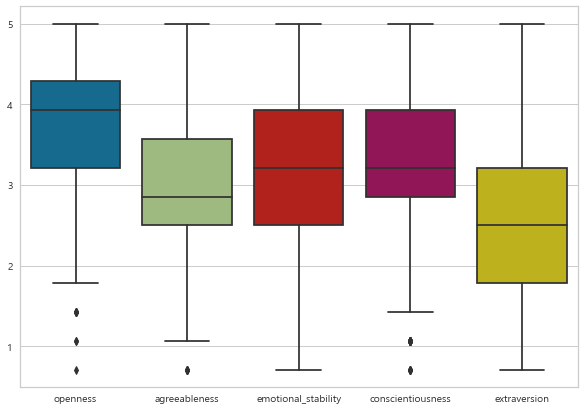

In [146]:
plt.figure(figsize=(10, 7 ))
sns.boxplot(data=df[personality]);

#### openness기준 다른 변수들과 관계 cluster로 구분

<Figure size 576x288 with 0 Axes>

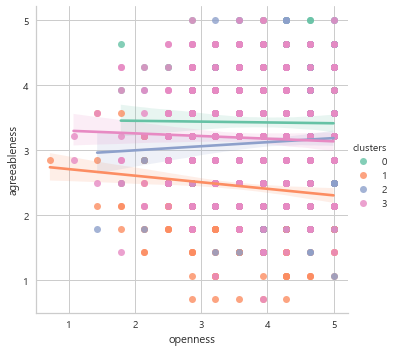

In [219]:
plt.figure(figsize=(8,4))
sns.lmplot(x='openness' , y='agreeableness',data=df, hue='clusters', palette='Set2')

<Figure size 576x288 with 0 Axes>

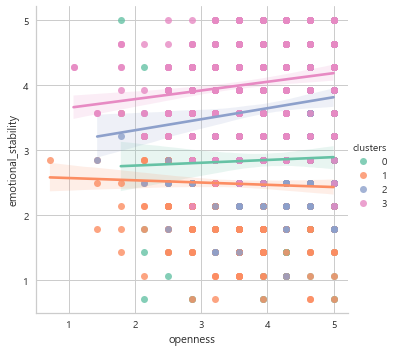

In [217]:
plt.figure(figsize=(8,4))
sns.lmplot(x='openness' , y='emotional_stability',data=df, hue='clusters', palette='Set2');

<Figure size 576x288 with 0 Axes>

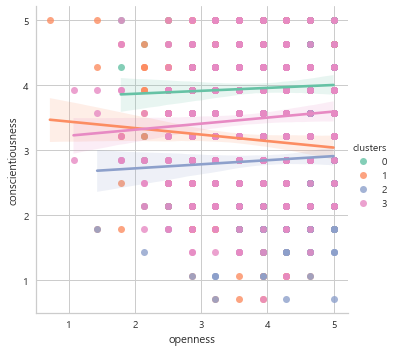

In [216]:
plt.figure(figsize=(8,4))
sns.lmplot(x='openness' , y='conscientiousness',data=df, hue='clusters', palette='Set2');

<Figure size 576x288 with 0 Axes>

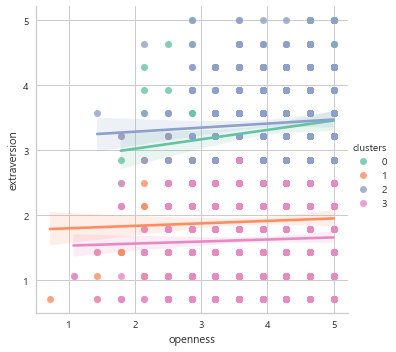

In [215]:
plt.figure(figsize=(8,4))
sns.lmplot(x='openness' , y='extraversion',data=df, hue='clusters', palette='Set2');

### 모델링

In [160]:
# split data
X = df.drop('clusters', axis=1)
y = df['clusters']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# 모델 설정
log_model = LogisticRegression(multi_class='multinomial') 
svm_model = SVC(C=1.0)
rf_model = RandomForestClassifier()
lgbm_model = LGBMClassifier()

# 학습
log_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train) 
lgbm_model.fit(X_train, y_train)

# 성능평가
log_acc = log_model.score(X_test, y_test)
svm_acc = svm_model.score(X_test, y_test)
rf_acc = rf_model.score(X_test, y_test)
lgbm_acc = lgbm_model.score(X_test, y_test)

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Logistic Regression 성능 평가

In [254]:
print(classification_report(y_test,log_model.predict(X_test)))
pd.DataFrame(confusion_matrix(y_test, log_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       101
           1       0.96      0.97      0.96       162
           2       0.95      0.95      0.95       137
           3       0.97      0.98      0.98       151

    accuracy                           0.96       551
   macro avg       0.96      0.95      0.96       551
weighted avg       0.96      0.96      0.96       551



,0,1,2,3
0,93,4,2,2
1,1,157,4,0
2,4,1,130,2
3,0,2,1,148


#### SVM 성능 평가

In [255]:
print(classification_report(y_test,svm_model.predict(X_test)))
pd.DataFrame(confusion_matrix(y_test, svm_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       101
           1       0.96      0.94      0.95       162
           2       0.94      0.97      0.95       137
           3       0.96      0.95      0.96       151

    accuracy                           0.95       551
   macro avg       0.95      0.95      0.95       551
weighted avg       0.95      0.95      0.95       551



,0,1,2,3
0,94,3,2,2
1,2,153,3,4
2,3,1,133,0
3,1,2,4,144


#### Random Forest 성능 평가

In [256]:
print(classification_report(y_test,rf_model.predict(X_test)))
pd.DataFrame(confusion_matrix(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       101
           1       0.93      0.91      0.92       162
           2       0.89      0.94      0.91       137
           3       0.92      0.93      0.93       151

    accuracy                           0.92       551
   macro avg       0.92      0.92      0.92       551
weighted avg       0.92      0.92      0.92       551



,0,1,2,3
0,88,2,7,4
1,1,148,8,5
2,3,2,129,3
3,1,8,1,141


#### LGBM Regression 성능 평가

In [257]:
print(classification_report(y_test,lgbm_model.predict(X_test)))
pd.DataFrame(confusion_matrix(y_test, lgbm_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       101
           1       0.93      0.92      0.93       162
           2       0.93      0.93      0.93       137
           3       0.95      0.93      0.94       151

    accuracy                           0.93       551
   macro avg       0.92      0.92      0.92       551
weighted avg       0.93      0.93      0.93       551



,0,1,2,3
0,92,3,3,3
1,5,149,5,3
2,5,2,128,2
3,2,6,2,141
